# Computing a simple alpha factor and its IC

In this notebook I'll be handling data to calculate the 12 month momentum of different stocks as a possible alpha factor. I'll be using the information coefficient to gauge the value of this alpha factor, which is explained below.

The Information Coefficient (IC) in finance measures an analyst's or model's forecasting skill by calculating the correlation between predicted returns and actual subsequent returns, helping to validate alpha models and manager performance. It's a key metric for assessing predictive power, showing how well rankings of stocks (e.g., "best to worst") align with their actual performance. 

### How it works
Calculation: It's typically a correlation coefficient (like Spearman's rank correlation) between the forecasted rankings or scores of assets and their actual realized returns over a period.

### Interpretation
+1: Perfect positive correlation (predictions consistently right).\
0: No correlation (no better than random guessing).\
-1: Perfect negative correlation (always predicts the opposite).

### Key applications
- Evaluating Alpha Models: Tests if a quantitative model's "alpha" (skill-based return) is reliable.
- Measuring Manager Skill: Assesses if a portfolio manager consistently picks winners.
- Portfolio Construction: Helps decide whether to rely more on strong signals (high IC) or a broader range of signals (breadth). 

In [1]:
import sys
sys.path.append(r"C:\Users\Sergio\Documents\GitHUb\Quant-trading-journey\src")
import quant_utils as qu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tickers = ['AAPL', 'TSLA', 'MSFT', 'NVDA', 'AVGO']
data = qu.data.download_data(tickers)

Saved → C:\Users\Sergio\Documents\GitHUb\Quant-trading-journey\src\data\AAPL+TSLA+MSFT+NVDA+AVGO_max_1d.pkl


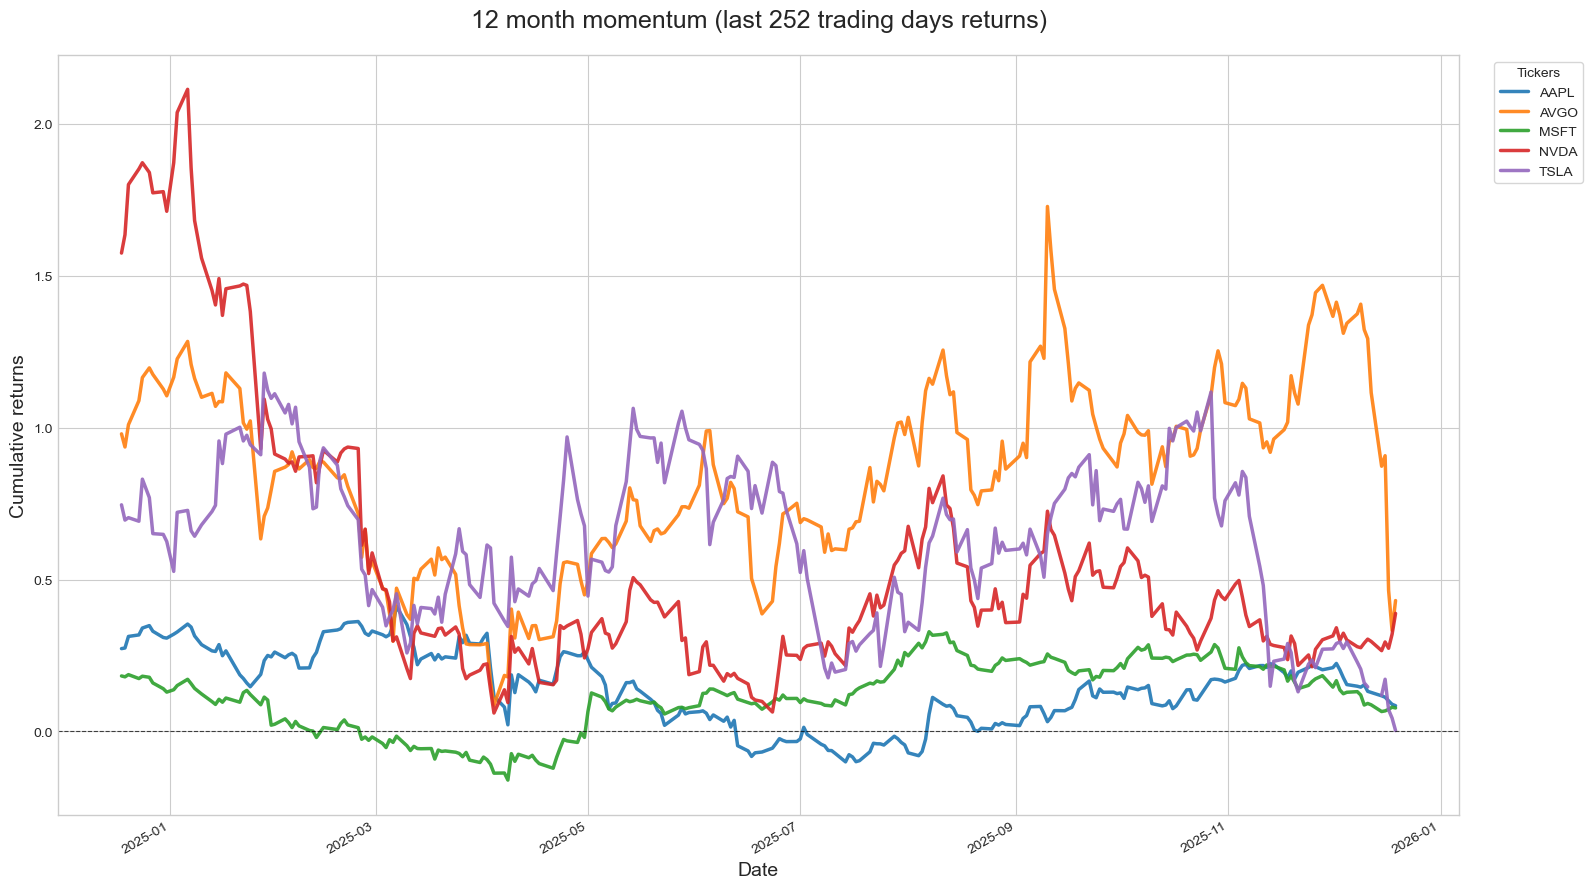

In [3]:
# Calculating rolling momentum for 12 months as alpha factor
returns = data.pct_change(fill_method=None)

n = 1 
days_per_year = 252 
rol_window = n * days_per_year

momentum = data.pct_change(periods=rol_window, fill_method=None)
momentum_last_year = momentum.tail(rol_window)

plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(16, 9))
momentum_last_year.plot(ax=ax, linewidth=2.5, alpha=0.9)

ax.set_title('12 month momentum (last 252 trading days returns)', fontsize=18, pad=20)
ax.set_ylabel('Cumulative returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.legend(title='Tickers', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True)

ax.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Interpretation

This chart alone is not significant for trading purposes. 
As the principle states: "past returns do not guarantee future returns."

What this plot shows:
- Historical momentum patterns for each ticker
- Relative performance differences between stocks
- Periods of high/low momentum

What we DON'T know yet (and need to validate):
- Signal quality: How much is real signal vs noise?
- Signal persistence: How long does momentum predict future returns before decaying?
- Predictive power: Is there actual correlation between current momentum and forward returns?

To answer these questions, we'll calculate the Information Coefficient (IC) - 
the correlation between today's momentum and future returns at various horizons.

In [23]:
# Measuring Information Coefficient (IC)

from scipy.stats import spearmanr

# Preparing the dataframe
forward_horizon = 21
forward_returns = data.pct_change(periods=forward_horizon, fill_method=None).shift(-forward_horizon)
momentum_ren = momentum.add_suffix('_factor')
forward_returns_ren = forward_returns.add_suffix('_forward')
aligned_data = pd.concat([momentum_ren, forward_returns_ren], axis=1).dropna()

ic_series = aligned_data.apply(lambda row: spearmanr(row[:5].values, row[5:].values)[0], axis=1)

print(f"\n{'='*60}")
print("Information coefficient results")
print(f"{'='*60}")
print(f"Average IC: {ic_series.mean():.4f}")
print(f"Median IC: {ic_series.median():.4f}")
print(f"Std IC: {ic_series.std():.4f}")
print(f"T-stat: {ic_series.mean() / ic_series.std() * np.sqrt(len(ic_series)):.2f}")


Information coefficient results
Average IC: 0.0504
Median IC: 0.1000
Std IC: 0.5526
T-stat: 5.49


## Interpretation

An **average IC of 0.0504** indicates weak but non-negligible predictive ability. The factor has marginal utility and should be combined with other signals rather than used standalone.

A **median IC of 0.10** is notably higher than the mean, suggesting the IC distribution is left-skewed. On typical days, the factor demonstrates decent predictive power, but occasional periods of strong negative correlation pull the average down.

The **standard deviation of 0.55** is approximately 10x the mean IC, indicating extremely high noise relative to signal. This is largely attributable to the small cross-sectional sample (only 5 tickers per day). With more assets, the IC would stabilize significantly.

The **t-statistic of 5.49** confirms statistical significance at the 99.9% confidence level (p < 0.001). Despite the weak magnitude, we can confidently reject the null hypothesis that IC equals zero. The factor exhibits genuine, albeit modest, predictive power.

**Key takeaway:** The factor is statistically real but economically weak. Its utility would improve substantially with (1) a larger asset universe and (2) combination with complementary factors.